In [ ]:
# #@title **Instalar Paquetes**

# !pip install open3d
# !pip install plotly

# Clonar el proyecto

*Nota: No es necesario cargar ningun tipo de informacion, solo se necesita clonar el repositorio del proyecto. Este documento debe trabajarse en colab.*

In [1]:
!git clone https://github.com/nick3153/Depth-Estimation-with-StereoThermal-Images.git
%cd Depth-Estimation-with-StereoThermal-Images

Cloning into 'Depth-Estimation-with-StereoThermal-Images'...
remote: Enumerating objects: 6019, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6019 (delta 0), reused 1 (delta 0), pack-reused 6017 (from 2)
Receiving objects: 100% (6019/6019), 1.56 GiB | 24.64 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/Depth-Estimation-with-StereoThermal-Images


In [2]:
#@title Librerias necesarias
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
import random
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
sns.set_theme()

In [3]:
#@title Funciones
def normalize(img):
    image = ((img - img.min()) / (img.max() - img.min())) * 255.0
    return image.astype(np.uint8)

def intensity_binding(img, lower_percentile:int=1, upper_percentile:int=99):
    # Calcular los percentiles
    low = np.percentile(img, lower_percentile)
    high = np.percentile(img, upper_percentile)

    # Recortar al rango [low, high]
    img_clipped = np.clip(img, low, high)

    # Normalizar
    img_norm = normalize(img_clipped)

    return img_norm

def apply_CLAHE(img):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def bilateral_filtering(img):
    return cv.bilateralFilter(img, d=5, sigmaColor=20, sigmaSpace=15)

def align_contrast(imgL, imgR):
    meanL = np.mean(imgL)
    meanR = np.mean(imgR)

    if meanR < meanL:
      imageR = imgR * (meanL/meanR)
      return imgL, imageR
    elif meanL < meanR:
      imageL = imgL * (meanR/meanL)
      return imageL, imgR

    return imgL, imgR

def preprocess_thermal_images(imgL, imgR, lower_percentile = 1, upper_percentile = 99):
    # Eliminar outlayers
    imageL = intensity_binding(imgL, lower_percentile, upper_percentile)
    imageR = intensity_binding(imgR, lower_percentile, upper_percentile)

    # Ecualizacion del histograma con clahe
    imageL = apply_CLAHE(imageL)
    imageR = apply_CLAHE(imageR)

    # Eliminacion de ruido
    imageL = bilateral_filtering(imageL)
    imageR = bilateral_filtering(imageR)

    # Alinear constrastes
    imageL, imageR = align_contrast(imageL, imageR)

    return imageL.astype(np.uint8), imageR.astype(np.uint8)

# =====================================================
# Funciones del semillero HOCV
# =====================================================

# Graficar mapas de profundidad
def plot_disparitymap(imgL,imgR,disparity_map):
    disparity_map[(disparity_map <= 0)] = 1

    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.imshow(imgL, cmap='gray')
    plt.axis('off')
    plt.title("Image Left")

    plt.subplot(132)
    plt.imshow(imgR, cmap='gray')
    plt.axis('off')
    plt.title("Image Right")

    plt.subplot(133)
    plt.imshow(disparity_map, cmap='viridis')
    plt.axis('off')
    plt.colorbar()
    plt.title('Disparity map')

# Graficar mapa de profundidad
def plot_depth_map(depth_map, umbral=2.0, cmap='viridis'):
    """
    Visualiza el mapa de profundidad y el histograma con un espacio visible en el medio.
    """

    depth = np.copy(depth_map)
    depth[depth <= 0] = np.nan
    depth[depth > umbral] = np.nan
    valid_depth = depth[~np.isnan(depth)]


    fig = plt.figure(figsize=(14, 4))
    spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1, 0.01, 1])


    ax1 = fig.add_subplot(spec[0])
    im = ax1.imshow(depth, cmap="jet_r")
    ax1.set_title("Mapa de profundidad")
    ax1.axis('off')
    cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label("Profundidad (m)")


    ax_blank = fig.add_subplot(spec[1])
    ax_blank.axis('off')


    ax2 = fig.add_subplot(spec[2])
    ax2.hist(valid_depth.ravel(), bins=50, color='teal')
    ax2.set_title("Histograma de profundidad")
    ax2.set_xlabel("Profundidad (m)")
    ax2.set_ylabel("Frecuencia")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 1. Exploración de los datos

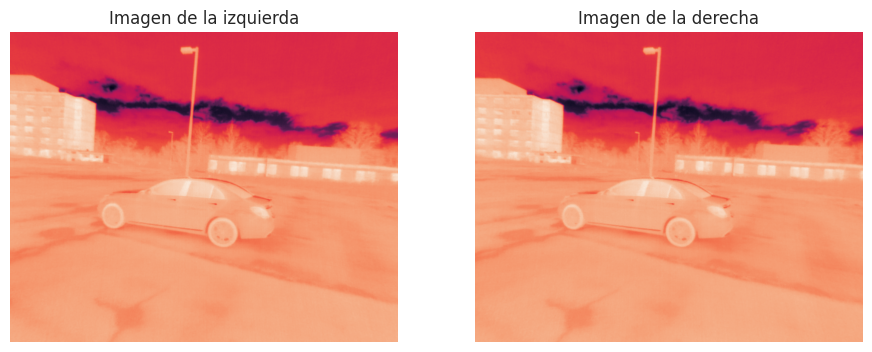

In [15]:
#@title Carga de imagenes termicas
## Ruta a las imagenes de prueba
imgs_path = '/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/hawkins_4/'

image_name = '01997.png'

## Leer imagenes
imgL = cv.imread(imgs_path + f"left/{image_name}", cv.IMREAD_UNCHANGED)
imgR = cv.imread(imgs_path + f"right/{image_name}", cv.IMREAD_UNCHANGED)

## Graficar/mostrar las imagenes
plt.figure(figsize=[11,7])
plt.subplot(121)
plt.imshow(imgL)
plt.title("Imagen de la izquierda")
plt.axis('off')
plt.subplot(122)
plt.imshow(imgR)
plt.title("Imagen de la derecha")
plt.axis('off')
plt.show()

In [16]:
#@title Caracteristicas de las imagenes

print('--'*30)

print("Imagen izquierda")
print('Profundidad de Bits: ', imgL.dtype)
print("Valor maximo = ", imgL.max(), "Valor minimo = ", imgL.min())
print("Valor promedio =  ", np.mean(imgL))
print('Tamaño: ', imgL.shape)

print("Imagen derecha")
print('Profundidad de Bits: ', imgR.dtype)
print("Valor maximo = ", imgR.max(), "Valor minimo = ", imgR.min())
print("Valor promedio =  ", np.mean(imgR))
print('Tamaño: ', imgR.shape)

print('--'*30)

------------------------------------------------------------
Imagen izquierda
Profundidad de Bits:  uint16
Valor maximo =  22699 Valor minimo =  20798
Valor promedio =   22168.65085144043
Tamaño:  (512, 640)
Imagen derecha
Profundidad de Bits:  uint16
Valor maximo =  22288 Valor minimo =  20251
Valor promedio =   21723.58088684082
Tamaño:  (512, 640)
------------------------------------------------------------


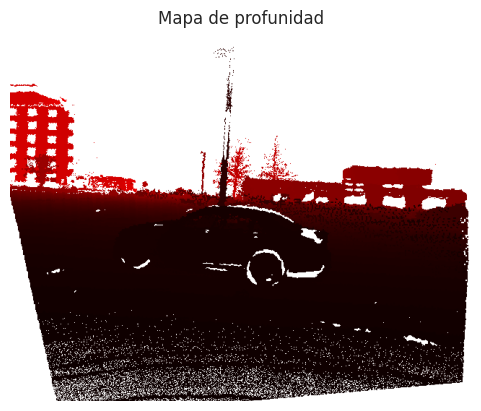

In [17]:
#@title Carga de los mapas de profundidad
## Leer mapas de profundidad
depth = cv.imread(imgs_path + f"depth/{image_name}", cv.IMREAD_UNCHANGED)
depth = 1 - depth

## Graficar/mostrar los mapas
plt.imshow(depth, cmap='hot_r')
plt.title("Mapa de profunidad")
plt.axis('off')
plt.show()

In [18]:
#@title Caracteristicas de los mapas de pronfidad
print('--'*30)

print("Mapa de profundida")
print('Profundidad de Bits: ', depth.dtype)
print("Valor maximo = ", depth.max(), "Valor minimo = ", depth.min())
print("Valor promedio =  ", np.mean(depth))
print('Tamaño: ', depth.shape)

print('--'*30)

------------------------------------------------------------
Mapa de profundida
Profundidad de Bits:  uint16
Valor maximo =  65288 Valor minimo =  1
Valor promedio =   33657.40715332031
Tamaño:  (512, 640)
------------------------------------------------------------


# 2. Preparación de las imagenes

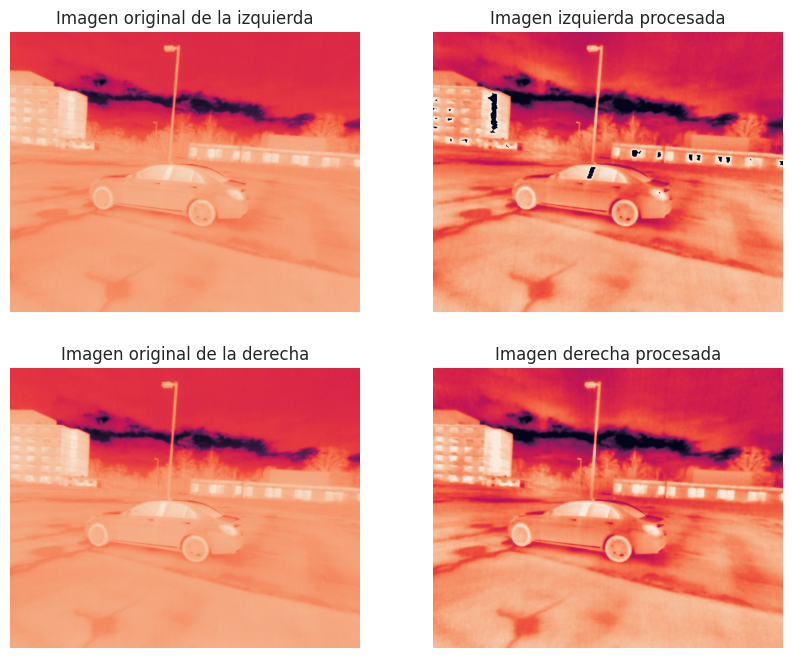

In [19]:
#@title Preprocesado
# Aplicar preprocesado
imageL, imageR = preprocess_thermal_images(imgL, imgR)

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(imgL)
plt.title('Imagen original de la izquierda')
plt.axis('off')
plt.subplot(222)
plt.imshow(imageL)
plt.title('Imagen izquierda procesada')
plt.axis('off')
plt.subplot(223)
plt.imshow(imgR)
plt.title('Imagen original de la derecha')
plt.axis('off')
plt.subplot(224)
plt.imshow(imageR)
plt.title('Imagen derecha procesada')
plt.axis('off')
plt.show()

# 3. Calculo de la disparidad y mapa de profundidad


*NOTA: Según el paper, las imagenes estereo termicas del dataset ya se encuentran rectificadas*

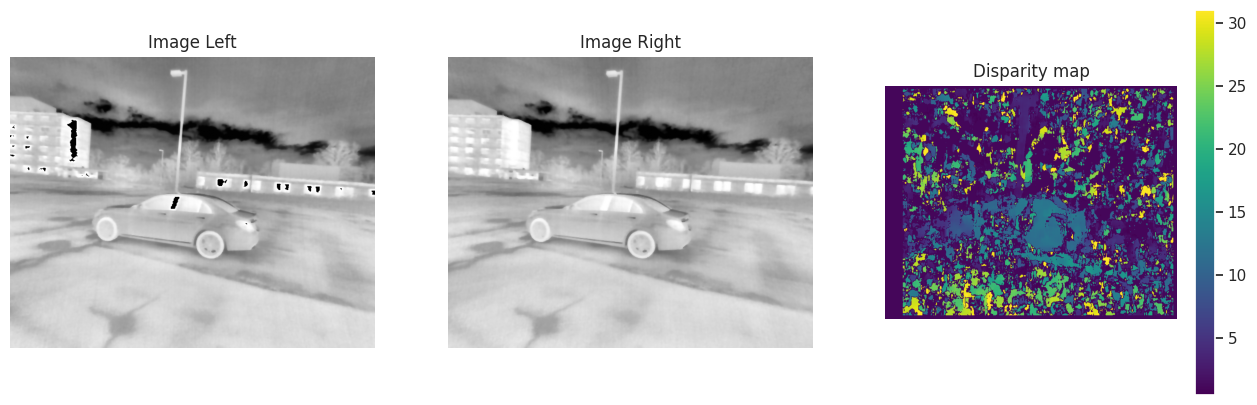

In [20]:
#@title Calculo del mapa de disparidad StereoBM
blocksize = 17
stereo = cv.StereoBM_create(numDisparities=32, blockSize=blocksize)
stereo.setPreFilterCap(5)
stereo.setUniquenessRatio(7)
stereo.setSpeckleWindowSize(0)
stereo.setSpeckleRange(0)
stereo.setTextureThreshold(10)

disp_bm = stereo.compute(imageL, imageR).astype(np.float32) / 16.0
plot_disparitymap(imageL, imageR, disp_bm)

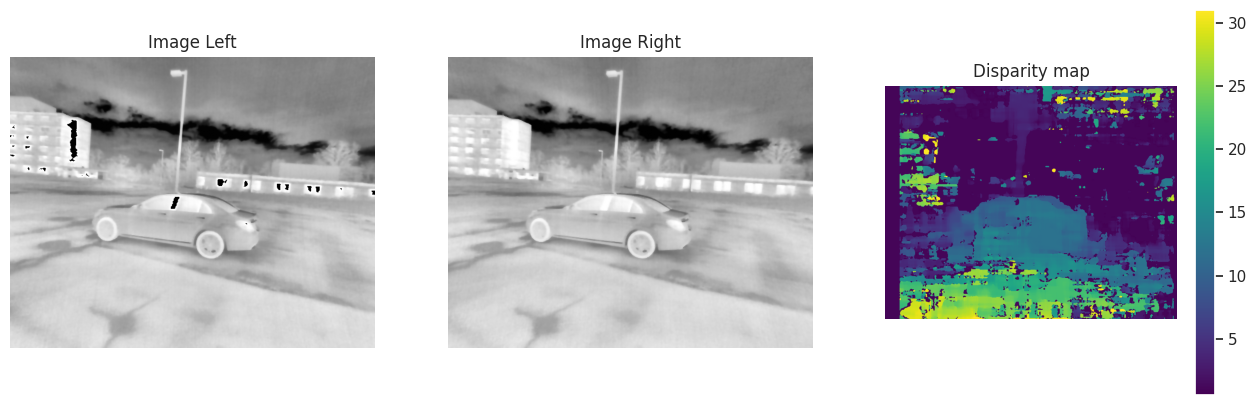

In [21]:
#@title Calculo del mapa de disparidad StereoSGBM
blocksize = 13
stereo = cv.StereoSGBM_create(minDisparity=0,
                              numDisparities=32,
                              blockSize=blocksize,
                              P1=8 * 1 * blocksize ** 2,
                              P2=32 * 1 * blocksize ** 2,
                              disp12MaxDiff=1,
                              uniquenessRatio=7,
                              speckleWindowSize=0,
                              speckleRange=0,
                              preFilterCap=5,
                              mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
                              )
disp_sgbm = stereo.compute(imageL, imageR).astype(np.float32) / 16.0
plot_disparitymap(imageL, imageR, disp_sgbm)

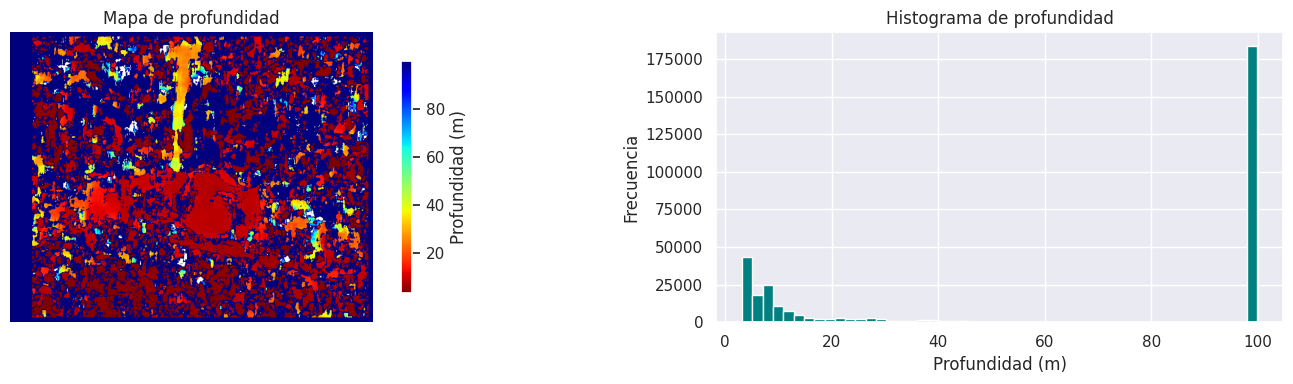

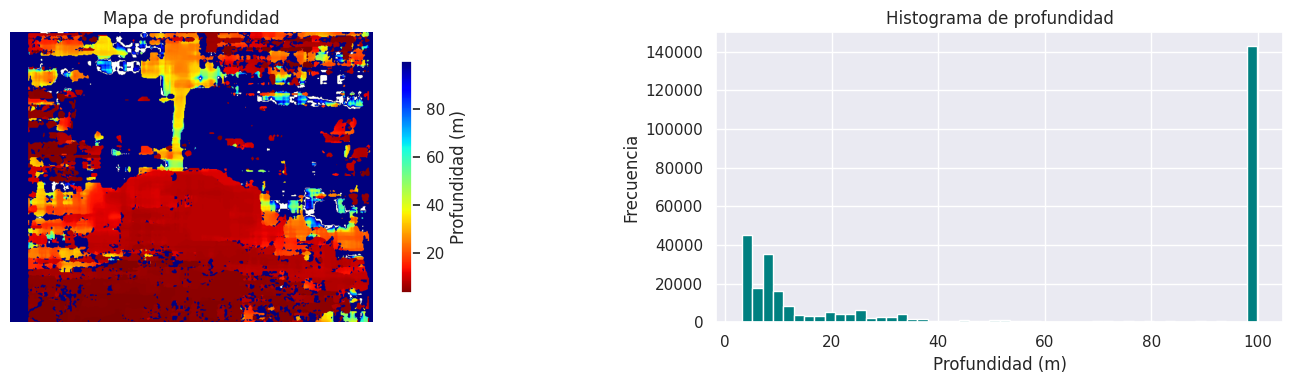

In [22]:
#@title calculo del mapa de profundidad
f = 406.33233091474426 # Distancia focal en pixeles
baseline = 0.24584925266278748 # Separacion entre las camaras en metros

# StereoBM
depth_bm_calc = (f * baseline) / (disp_bm + 1e-6)
plot_depth_map(depth_bm_calc, umbral=100)

# StereoSGBM
depth_sgbm_calc = (f * baseline) / (disp_sgbm + 1e-6)
plot_depth_map(depth_sgbm_calc, umbral=100)

In [23]:
#@title Caracteristicas del mapa de pronfidad calculado
print('--'*30)
print("Mapa de profundida StereoBM")
print('Profundidad de Bits: ', depth_bm_calc.dtype)
print("Valor maximo = ", depth_bm_calc.max(), "Valor minimo = ", depth_bm_calc.min())
print("Valor promedio =  ", np.mean(depth_bm_calc))
print('Tamaño: ', depth_bm_calc.shape)
print('--'*30)
print("Mapa de profundida StereoBM")
print('Profundidad de Bits: ', depth_sgbm_calc.dtype)
print("Valor maximo = ", depth_sgbm_calc.max(), "Valor minimo = ", depth_sgbm_calc.min())
print("Valor promedio =  ", np.mean(depth_sgbm_calc))
print('Tamaño: ', depth_sgbm_calc.shape)
print('--'*30)

------------------------------------------------------------
Mapa de profundida StereoBM
Profundidad de Bits:  float32
Valor maximo =  199.79259 Valor minimo =  3.2224674
Valor promedio =   62.76481
Tamaño:  (512, 640)
------------------------------------------------------------
Mapa de profundida StereoBM
Profundidad de Bits:  float32
Valor maximo =  177.59346 Valor minimo =  3.2224674
Valor promedio =   53.67518
Tamaño:  (512, 640)
------------------------------------------------------------


------------------------------------------------------------
Errores StereoBM
MAE = 133.41072998046874
RMSE = 152.0811927421566
------------------------------------------------------------
Errores StereoSGBM
MAE = 147.65748596191406
RMSE = 167.34119352464603
------------------------------------------------------------


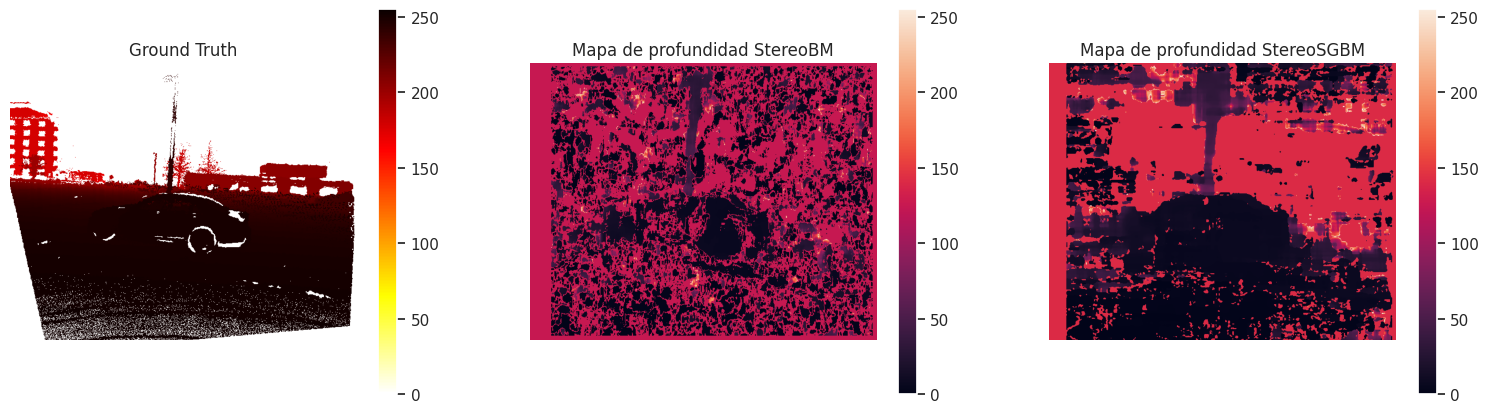

In [24]:
#@title Comparación entre el depth calculado y el ground truth
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

# Normalizar el depth calculado y pasarlo a uint8
depth_bm_calc = normalize(depth_bm_calc)
depth_sgbm_calc = normalize(depth_sgbm_calc)

# Normalizar el ground truth y pasarlo a uint8
ground_truth = normalize(depth)

# Calculo de errores
mae_bm = mean_absolute_error(ground_truth, depth_bm_calc)
rmse_bm = root_mean_squared_error(ground_truth, depth_bm_calc)
mae_sgbm = mean_absolute_error(ground_truth, depth_sgbm_calc)
rmse_sgbm = root_mean_squared_error(ground_truth, depth_sgbm_calc)

print('--'*30)
print('Errores StereoBM')
print(f'MAE = {mae_bm}')
print(f'RMSE = {rmse_bm}')
print('--'*30)
print('Errores StereoSGBM')
print(f'MAE = {mae_sgbm}')
print(f'RMSE = {rmse_sgbm}')
print('--'*30)

plt.figure(figsize=(19,5))
plt.subplot(131)
plt.imshow(ground_truth, cmap='hot_r')
plt.title('Ground Truth')
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.imshow(depth_bm_calc)
plt.title('Mapa de profundidad StereoBM')
plt.colorbar()
plt.axis('off')
plt.subplot(133)
plt.imshow(depth_sgbm_calc)
plt.title('Mapa de profundidad StereoSGBM')
plt.colorbar()
plt.axis('off')
plt.show()